In [705]:
# Isaac Berez
# 17.01.23
import sys
from scipy.io import mmread
import os
import glob
import pandas as pd
import numpy as np
#from pandas_ods_reader import read_ods
from copy import deepcopy
import pprint
import json
import re
from datetime import datetime
import logging
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import harmonypy as hm
from matplotlib.cm import ScalarMappable
from datetime import date
import mpld3
import hvplot.pandas
import holoviews as hv
from holoviews import opts
import panel as pn
import bokeh
from bokeh.resources import INLINE
from adjustText import adjust_text
from scipy.stats import mannwhitneyu, false_discovery_control, wilcoxon
import matplotlib as mpl




import dimorph_processing as dp
import cell_comparison as cc
import sex_stats as ss
import sig_gene_analysis as sga
import run_sig_genes as rsg

today = str(date.today())
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [724]:
#plt.rcdefaults()

#change matplotlib font type to make compatibile with illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42



In [826]:
#gaba_all_genes_folder = '/bigdata/isaac/gaba_files/sex_stats/volcano_plots/171224_run/'
#gaba_all_genes_folder = '/bigdata/isaac/gaba_files/sex_stats/191224_run/volcano_plots/'
gaba_all_genes_folder = '/bigdata/isaac/gaba_files/sex_stats/221224_run/volcano_plots/'

gaba_all_genes_df = pd.read_csv(gaba_all_genes_folder + 'all_genes.csv',header=None)
gaba_all_genes_df.rename(columns = {0:'cluster_fn',1:'test',2:'gene',3:'delta',4:'p_adj'}, 
            inplace = True)
gaba_all_genes_df.head()

,cluster_fn,test,gene,delta,p_adj
0,GABA-1-Sst-Npy-Spon1,ΔBN_m,0610007P14Rik,-0.263807,0.161028
1,GABA-1-Sst-Npy-Spon1,ΔBN_m,0610009B22Rik,-0.194144,0.238959
2,GABA-1-Sst-Npy-Spon1,ΔBN_m,0610009L18Rik,-0.021667,0.977246
3,GABA-1-Sst-Npy-Spon1,ΔBN_m,0610009O20Rik,-0.027129,0.915039
4,GABA-1-Sst-Npy-Spon1,ΔBN_m,0610010F05Rik,-0.297043,0.071911


In [827]:
gaba_all_genes_df.shape

(922084, 5)

In [829]:
#gaba_sex_stats_folder = '/bigdata/isaac/gaba_files/sex_stats/191224_run/'
gaba_sex_stats_folder = '/bigdata/isaac/gaba_files/sex_stats/221224_run/'
gaba_metadata_df_dlr = pd.read_json(gaba_sex_stats_folder + 'gaba_metadata_df_dlr.json')
#gaba_df_dlr = pd.read_feather(gaba_sex_stats_folder + 'gaba_df_dlr.feather')

In [830]:
gaba_metadata_df_dlr.tail()

,CTCGAGGCATCCGTTC-1_10X52_3,GTCCTCACACGACCTG-1_10X52_2,GGCTTGGGTCGGTACC-1_10X52_2,GGGAGTATCAGACCTA-1_10X52_3,CGTGCTTTCAAAGAAC-1_10X51_2,CGCAGGTTCGGTTAGT-1_10X52_1,CTACGGGCAGTCTCTC-1_10X51_2,AGGAGGTTCATTTGGG-1_10X35_1,ATCAGGTCACGAAGAC-1_10X36_2,CAAGGGAGTTCCACAA-1_10X38_2,...,AAGGAATTCGTTCGCT-1_10X52_4,CGGGTCACAAAGTGTA-1_10X36_1,CATGCTCTCCGAAATC-1_10X37_2,AGTCACATCCCTGGTT-1_10X36_2,TGTCCCAGTTGGAGAC-1_10X35_2,CAAGGGACACTTGGGC-1_10X38_1,TGGTACAAGAACTCCT-1_10X51_1,AGGTCATAGCGTTAGG-1_10X36_2,TACGCTCCACAGTCCG-1_10X52_3,TGTCCACAGCTATCTG-1_10X37_2
Sample_Index,F12,E12,E12,F12,A2,D12,A2,D9,A9,C9,...,G12,H8,F9,A9,G8,B9,G1,A9,F12,F9
cell_class,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,...,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA
cluster_label,1,1,1,1,1,1,1,1,1,1,...,33,33,33,33,33,33,33,33,33,33
markers,Sst-Npy-Spon1,Sst-Npy-Spon1,Sst-Npy-Spon1,Sst-Npy-Spon1,Sst-Npy-Spon1,Sst-Npy-Spon1,Sst-Npy-Spon1,Sst-Npy-Spon1,Sst-Npy-Spon1,Sst-Npy-Spon1,...,Cartpt-Unc13c,Cartpt-Unc13c,Cartpt-Unc13c,Cartpt-Unc13c,Cartpt-Unc13c,Cartpt-Unc13c,Cartpt-Unc13c,Cartpt-Unc13c,Cartpt-Unc13c,Cartpt-Unc13c
full_name,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,...,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c


In [831]:
_, idx = np.unique(gaba_metadata_df_dlr.loc['full_name'], return_index=True)
gaba_fn = np.array(gaba_metadata_df_dlr.loc['full_name'][np.sort(idx)])
gaba_fn

/tmp/ipykernel_3471919/360179944.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gaba_fn = np.array(gaba_metadata_df_dlr.loc['full_name'][np.sort(idx)])


array(['GABA-1-Sst-Npy-Spon1', 'GABA-2-Sst-Npy-Maf',
       'GABA-3-Sst-Npy-Chodl', 'GABA-4-Moxd1-Pvalb', 'GABA-5-Moxd1-Vwc2',
       'GABA-6-Hapln1-Cryab', 'GABA-7-Vip-Crh', 'GABA-8-Htr3a-Rgs12',
       'GABA-9-Dab1-Myh7', 'GABA-10-Pax6-Npnt', 'GABA-11-Pax6-Calca',
       'GABA-12-Sncg-Reln', 'GABA-13-Fign-Lrpprc', 'GABA-14-Isl1-Gal',
       'GABA-15-Igsf1-Zfhx3', 'GABA-16-Lmo1-Chn2', 'GABA-17-Isl1-Pou3f2',
       'GABA-18-Meis2-Dach1', 'GABA-19-Meis2-Tshz1',
       'GABA-20-Meis2-Foxp2', 'GABA-21-Meis2-Nwd2',
       'GABA-22-Col23a1-Hs3st4', 'GABA-23-Pde11a-Npy2r',
       'GABA-24-Prlr-St18', 'GABA-25-Oprk1-Trhde',
       'GABA-26-Col18a1-Jsrp1', 'GABA-27-Greb1-Dlk1',
       'GABA-28-Lypd1-Satb1', 'GABA-29-Lpyd1-Unc13c',
       'GABA-30-Cbln4-Zbtb20', 'GABA-31-Fign-Foxp2',
       'GABA-32-Cartpt-Dkk2', 'GABA-33-Cartpt-Unc13c'], dtype=object)

In [832]:
gaba_all_genes_df_formatted = sga.format_genes(gaba_all_genes_df,gaba_metadata_df_dlr, gaba_fn,gaba_all_genes_folder, 'all_genes_formatted',write_to_file=False)

In [833]:
gaba_all_genes_df_formatted

,delta,p_adj,delta,p_adj,delta,p_adj,delta,p_adj,delta,p_adj,...,delta,p_adj,delta,p_adj,delta,p_adj,delta,p_adj,delta,p_adj
cluster_fn,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-2-Sst-Npy-Maf,GABA-2-Sst-Npy-Maf,...,GABA-32-Cartpt-Dkk2,GABA-32-Cartpt-Dkk2,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c
test,ΔBN_m,ΔBN_m,ΔBN_f,ΔBN_f,Δmf_B,Δmf_B,Δmf_N,Δmf_N,ΔBN_m,ΔBN_m,...,Δmf_N,Δmf_N,ΔBN_m,ΔBN_m,ΔBN_f,ΔBN_f,Δmf_B,Δmf_B,Δmf_N,Δmf_N
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,-0.263807,0.161028,-0.137111,0.778149,-0.042942,1.0,0.083754,1.0,-0.185239,0.590477,...,0.585306,1.0,-0.265995,0.044797,-0.380083,0.043998,-0.004826,0.998647,-0.118914,0.977294
0610009B22Rik,-0.194144,0.238959,-0.158309,0.615995,-0.066060,1.0,-0.030225,1.0,-0.003091,0.989220,...,0.042348,1.0,-0.185609,0.179393,-0.124833,0.733542,-0.006434,0.998647,0.054342,0.999907
0610009L18Rik,-0.021667,0.977246,0.023485,0.974129,0.002705,1.0,0.047856,1.0,-0.008203,0.988506,...,0.082949,1.0,0.031559,0.881839,0.035872,0.970984,-0.020928,0.998647,-0.016615,0.999907
0610009O20Rik,-0.027129,0.915039,-0.027707,0.991163,0.015589,1.0,0.015010,1.0,-0.065493,0.930175,...,0.005045,1.0,-0.072216,0.637605,-0.068053,0.906050,-0.053000,0.998647,-0.048837,0.999907
0610010F05Rik,-0.297043,0.071911,-0.132040,0.718766,-0.003303,1.0,0.161700,1.0,-0.236191,0.337007,...,-0.076595,1.0,-0.136767,0.296803,-0.221424,0.322396,0.101421,0.998647,0.016763,0.999907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tmem26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.096315,0.546602,0.086504,0.911109,-0.200616,0.885827,-0.017797,0.999907


In [834]:
#get stat sig genes based on following criteria
log_fc = np.log2(1.5) #(log2(1.5))
alpha = 0.05

In [835]:
gaba_all_genes_df

,cluster_fn,test,gene,delta,p_adj
0,GABA-1-Sst-Npy-Spon1,ΔBN_m,0610007P14Rik,-0.263807,0.161028
1,GABA-1-Sst-Npy-Spon1,ΔBN_m,0610009B22Rik,-0.194144,0.238959
2,GABA-1-Sst-Npy-Spon1,ΔBN_m,0610009L18Rik,-0.021667,0.977246
3,GABA-1-Sst-Npy-Spon1,ΔBN_m,0610009O20Rik,-0.027129,0.915039
4,GABA-1-Sst-Npy-Spon1,ΔBN_m,0610010F05Rik,-0.297043,0.071911
...,...,...,...,...,...
922079,GABA-33-Cartpt-Unc13c,Δmf_N,Zyg11b,0.210153,0.656939
922080,GABA-33-Cartpt-Unc13c,Δmf_N,Zzef1,0.183292,0.719527
922081,GABA-33-Cartpt-Unc13c,Δmf_N,Zzz3,0.001575,0.999907
922082,GABA-33-Cartpt-Unc13c,Δmf_N,l7Rn6,-0.085213,0.999907


In [836]:
gaba_sig_genes = gaba_all_genes_df.iloc[np.where((np.abs(gaba_all_genes_df.loc[:,'delta'])>log_fc) & (gaba_all_genes_df['p_adj'] < alpha))]
#gaba_sig_genes = gaba_all_genes_df.iloc[np.where(gaba_all_genes_df['p_adj'] < alpha)]
gaba_sig_genes

,cluster_fn,test,gene,delta,p_adj
1047,GABA-1-Sst-Npy-Spon1,ΔBN_m,Cct5,-0.634634,3.026165e-04
1110,GABA-1-Sst-Npy-Spon1,ΔBN_m,Cdkn2d,-0.590485,5.038371e-04
1169,GABA-1-Sst-Npy-Spon1,ΔBN_m,Chchd4,-0.652496,2.505501e-04
1696,GABA-1-Sst-Npy-Spon1,ΔBN_m,Dlg4,-0.617750,1.060355e-03
2541,GABA-1-Sst-Npy-Spon1,ΔBN_m,Gmps,-0.587455,1.856598e-03
...,...,...,...,...,...
919034,GABA-33-Cartpt-Unc13c,Δmf_N,Odc1,0.591706,1.221922e-04
919407,GABA-33-Cartpt-Unc13c,Δmf_N,Plxna2,0.732233,6.846000e-07
920675,GABA-33-Cartpt-Unc13c,Δmf_N,Sox5,0.668074,3.497000e-07
920748,GABA-33-Cartpt-Unc13c,Δmf_N,Srrm4,0.625103,7.096000e-07


In [776]:
#filtering sanity checks
np.where(np.abs(gaba_sig_genes.loc[:,'p_adj']) > alpha)

(array([], dtype=int64),)

In [777]:
np.where(np.abs(gaba_sig_genes.loc[:,'delta']) < log_fc)

(array([], dtype=int64),)

In [813]:
gaba_index = list(np.unique(gaba_sig_genes['gene']))
len(gaba_index)

622

In [837]:
gaba_sig_full = gaba_all_genes_df_formatted.loc[gaba_index]
gaba_sig_full

,delta,p_adj,delta,p_adj,delta,p_adj,delta,p_adj,delta,p_adj,...,delta,p_adj,delta,p_adj,delta,p_adj,delta,p_adj,delta,p_adj
cluster_fn,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-1-Sst-Npy-Spon1,GABA-2-Sst-Npy-Maf,GABA-2-Sst-Npy-Maf,...,GABA-32-Cartpt-Dkk2,GABA-32-Cartpt-Dkk2,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c,GABA-33-Cartpt-Unc13c
test,ΔBN_m,ΔBN_m,ΔBN_f,ΔBN_f,Δmf_B,Δmf_B,Δmf_N,Δmf_N,ΔBN_m,ΔBN_m,...,Δmf_N,Δmf_N,ΔBN_m,ΔBN_m,ΔBN_f,ΔBN_f,Δmf_B,Δmf_B,Δmf_N,Δmf_N
gene,,,,,,,,,,,,,,,,,,,,,
0610011F06Rik,-0.156479,0.469220,-0.296119,0.248226,0.130410,1.0,-0.009230,1.0,-0.237285,0.366425,...,-0.163459,1.0,-0.197156,0.157896,-0.117587,0.781999,-0.147915,0.998647,-0.068346,0.999907
0610012G03Rik,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.471473,0.000861,-0.215928,0.436616,-0.116438,0.998647,0.139107,0.944859
1110001J03Rik,-0.044125,0.916738,-0.131509,0.751671,0.026483,1.0,-0.060901,1.0,-0.132729,0.856984,...,-0.057725,1.0,-0.176861,0.265592,-0.200981,0.462146,-0.080832,0.998647,-0.104953,0.977294
1110008F13Rik,-0.432203,0.022107,-0.041551,0.954629,-0.169406,1.0,0.221246,1.0,-0.207618,0.644395,...,0.297370,1.0,-0.266948,0.046300,0.024081,0.988152,-0.159728,0.951860,0.131301,0.940501
1110065P20Rik,-0.396915,0.052811,-0.318347,0.241994,-0.140659,1.0,-0.062091,1.0,-0.540372,0.008156,...,NaN,NaN,-0.147139,0.367374,-0.203432,0.472653,-0.045835,0.998647,-0.102128,0.999907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zc2hc1a,-0.392097,0.100807,-0.171227,0.765243,-0.002130,1.0,0.218739,1.0,-0.196441,0.563672,...,0.345622,1.0,-0.256850,0.077893,-0.204257,0.472653,0.028221,0.998647,0.080814,0.999907


In [448]:
np.where(gaba_sig_full.loc['Zmynd8',:]  != np.nan)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [ ]:
#remove any 

In [838]:
gaba_sig_deltas = gaba_sig_full.iloc[:,::2]
gaba_sig_deltas

delta                                \
cluster_fn    GABA-1-Sst-Npy-Spon1                                 
test                         ΔBN_m     ΔBN_f     Δmf_B     Δmf_N   
gene                                                               
0610011F06Rik            -0.156479 -0.296119  0.130410 -0.009230   
0610012G03Rik                  NaN       NaN       NaN       NaN   
1110001J03Rik            -0.044125 -0.131509  0.026483 -0.060901   
1110008F13Rik            -0.432203 -0.041551 -0.169406  0.221246   
1110065P20Rik            -0.396915 -0.318347 -0.140659 -0.062091   
...                            ...       ...       ...       ...   
Zc2hc1a                  -0.392097 -0.171227 -0.002130  0.218739   
Zdbf2                    -0.227397 -0.144675 -0.035338  0.047383   
Zfp207                   -0.155437 -0.442193  0.096890 -0.189865   
Zfp638                   -0.408996 -0.373403 -0.007330  0.028262   
Zmynd8                         NaN       NaN       NaN       NaN   

                                                                \
cluster_fn    GABA-2-Sst-Npy-Maf                                 
test                       ΔBN_m     ΔBN_f     Δmf_B     Δmf_N   
gene                                                             
0610011F06Rik          -0.237285 -0.197111 -0.043576 -0.003403   
0610012G03Rik                NaN       NaN       NaN       NaN   
1110001J03Rik          -0.132729 -0.201087 -0.284612 -0.352970   
1110008F13Rik          -0.207618 -0.391373  0.130151 -0.053604   
1110065P20Rik          -0.540372 -0.239234 -0.051479  0.249658   
...                          ...       ...       ...       ...   
Zc2hc1a                -0.196441 -0.198041 -0.063817 -0.065417   
Zdbf2                  -0.389728 -0.325918 -0.317011 -0.253201   
Zfp207                 -0.391765 -0.207513 -0.064066  0.120186   
Zfp638                 -0.258308 -0.353904  0.043904 -0.051693   
Zmynd8                       NaN       NaN       NaN       NaN   

                                              ...                     \
cluster_fn    GABA-3-Sst-Npy-Chodl            ... GABA-31-Fign-Foxp2   
test                         ΔBN_m     ΔBN_f  ...              Δmf_B   
gene                                          ...                      
0610011F06Rik            -0.622657 -0.453885  ...          -0.058936   
0610012G03Rik                  NaN       NaN  ...                NaN   
1110001J03Rik            -0.212999 -0.346684  ...          -0.014913   
1110008F13Rik            -0.251236 -0.518881  ...          -0.139902   
1110065P20Rik                  NaN       NaN  ...           0.037076   
...                            ...       ...  ...                ...   
Zc2hc1a                  -0.311546 -0.476942  ...          -0.022652   
Zdbf2                    -0.053667 -0.393156  ...          -0.329405   
Zfp207                    0.092231 -0.264160  ...           0.111649   
Zfp638                   -0.384570 -0.257992  ...          -0.081053   
Zmynd8                         NaN       NaN  ...                NaN   

                                                                           \
cluster_fn              GABA-32-Cartpt-Dkk2                                 
test              Δmf_N               ΔBN_m     ΔBN_f     Δmf_B     Δmf_N   
gene                                                                        
0610011F06Rik -0.133485           -0.051830 -0.341425  0.126136 -0.163459   
0610012G03Rik       NaN                 NaN       NaN       NaN       NaN   
1110001J03Rik -0.094968           -0.059664 -0.059291 -0.058098 -0.057725   
1110008F13Rik -0.243318           -0.236639 -0.083566  0.144297  0.297370   
1110065P20Rik  0.067361                 NaN       NaN       NaN       NaN   
...                 ...                 ...       ...       ...       ...   
Zc2hc1a        0.103876           -0.252709 -0.039527  0.132441  0.345622   
Zdbf2         -0.333397                 NaN       NaN       NaN       NaN   
Zfp207      

In [839]:
gaba_sig_p_adj = gaba_sig_full.iloc[:,1::2]
gaba_sig_p_adj

p_adj                                           \
cluster_fn    GABA-1-Sst-Npy-Spon1                       GABA-2-Sst-Npy-Maf   
test                         ΔBN_m     ΔBN_f Δmf_B Δmf_N              ΔBN_m   
gene                                                                          
0610011F06Rik             0.469220  0.248226   1.0   1.0           0.366425   
0610012G03Rik                  NaN       NaN   NaN   NaN                NaN   
1110001J03Rik             0.916738  0.751671   1.0   1.0           0.856984   
1110008F13Rik             0.022107  0.954629   1.0   1.0           0.644395   
1110065P20Rik             0.052811  0.241994   1.0   1.0           0.008156   
...                            ...       ...   ...   ...                ...   
Zc2hc1a                   0.100807  0.765243   1.0   1.0           0.563672   
Zdbf2                     0.342528  0.790534   1.0   1.0           0.110838   
Zfp207                    0.594109  0.083391   1.0   1.0           0.049931   
Zfp638                    0.066572  0.209537   1.0   1.0           0.341721   
Zmynd8                         NaN       NaN   NaN   NaN                NaN   

                                                                        ...  \
cluster_fn                              GABA-3-Sst-Npy-Chodl            ...   
test              ΔBN_f Δmf_B     Δmf_N                ΔBN_m     ΔBN_f  ...   
gene                                                                    ...   
0610011F06Rik  0.634958   1.0  0.997993                  1.0  0.998227  ...   
0610012G03Rik       NaN   NaN       NaN                  NaN       NaN  ...   
1110001J03Rik  0.576418   1.0  0.997993                  1.0  0.998227  ...   
1110008F13Rik  0.152090   1.0  0.997993                  1.0  0.998227  ...   
1110065P20Rik  0.432341   1.0  0.997993                  NaN       NaN  ...   
...                 ...   ...       ...                  ...       ...  ...   
Zc2hc1a        0.534162   1.0  0.997993                  1.0  0.998227  ...   
Zdbf2          0.245516   1.0  0.997993                  1.0  0.998227  ...   
Zfp207         0.384452   1.0  0.997993                  1.0  0.998227  ...   
Zfp638         0.234409   1.0  0.997993                  1.0  0.998227  ...   
Zmynd8              NaN   NaN       NaN                  NaN       NaN  ...   

                                                                              \
cluster_fn    GABA-31-Fign-Foxp2       GABA-32-Cartpt-Dkk2                     
test                       Δmf_B Δmf_N               ΔBN_m ΔBN_f Δmf_B Δmf_N   
gene                                                                           
0610011F06Rik                1.0   1.0                 1.0   1.0   1.0   1.0   
0610012G03Rik                NaN   NaN                 NaN   NaN   NaN   NaN   
1110001J03Rik                1.0   1.0                 1.0   1.0   1.0   1.0   
1110008F13Rik                1.0   1.0                 1.0   1.0   1.0   1.0   
1110065P20Rik                1.0   1.0                 NaN   NaN   NaN   NaN   
...                          ...   ...                 ...   ...   ...   ...   
Zc2hc1a                      1.0   1.0                 1.0   1.0   1.0   1.0   
Zdbf2                        1.0   1.0                 NaN   NaN   NaN   NaN   
Zfp207                       1.0   1.0                 1.0   1.0   1.0   1.0   
Zfp638                       1.0   1.0                 1.0   1.0   1.0   1.0   
Zmynd8                       NaN   NaN                 NaN   NaN   NaN   NaN   

                                                                   
cluster_fn    GABA-33-Cartpt-Unc13c                                
test                          ΔBN_m     ΔBN_f     Δmf_B     Δmf_N  
gene                                                               
0610011F06Rik              0.157896  0.781999  0.998647  0.999907  
0610012G03Rik              0.000861  0.436616  0.998647  0.944859  
1110001J03Rik              0.265592  0.462146  0

In [840]:
#isolate delta and p values for each test
gaba_sig_deltas_ΔBN_m = gaba_sig_deltas.iloc[:,::4]
gaba_sig_p_adj_ΔBN_m = gaba_sig_p_adj.iloc[:,::4]
gaba_sig_deltas_ΔBN_f = gaba_sig_deltas.iloc[:,1::4]
gaba_sig_p_adj_ΔBN_f = gaba_sig_p_adj.iloc[:,1::4]
gaba_sig_deltas_Δmf_B = gaba_sig_deltas.iloc[:,2::4]
gaba_sig_p_adj_Δmf_B = gaba_sig_p_adj.iloc[:,2::4]
gaba_sig_deltas_Δmf_N = gaba_sig_deltas.iloc[:,3::4]
gaba_sig_p_adj_Δmf_N = gaba_sig_p_adj.iloc[:,3::4]


In [821]:
#gaba_sig_gene_heatmap_folder = '/bigdata/isaac/gaba_files/sex_stats/191224_run/sig_gene_heatmaps/'
gaba_sig_gene_heatmap_folder = '/bigdata/isaac/gaba_files/sex_stats/261224_run/sig_gene_heatmaps/'


subset: 55


/home/isaac/analysis/scRNA-seq/sig_gene_analysis.py:161: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  plt.plot(cols+0.5,rows+0.5,'k.',markersize = 10,c = 'yellow')


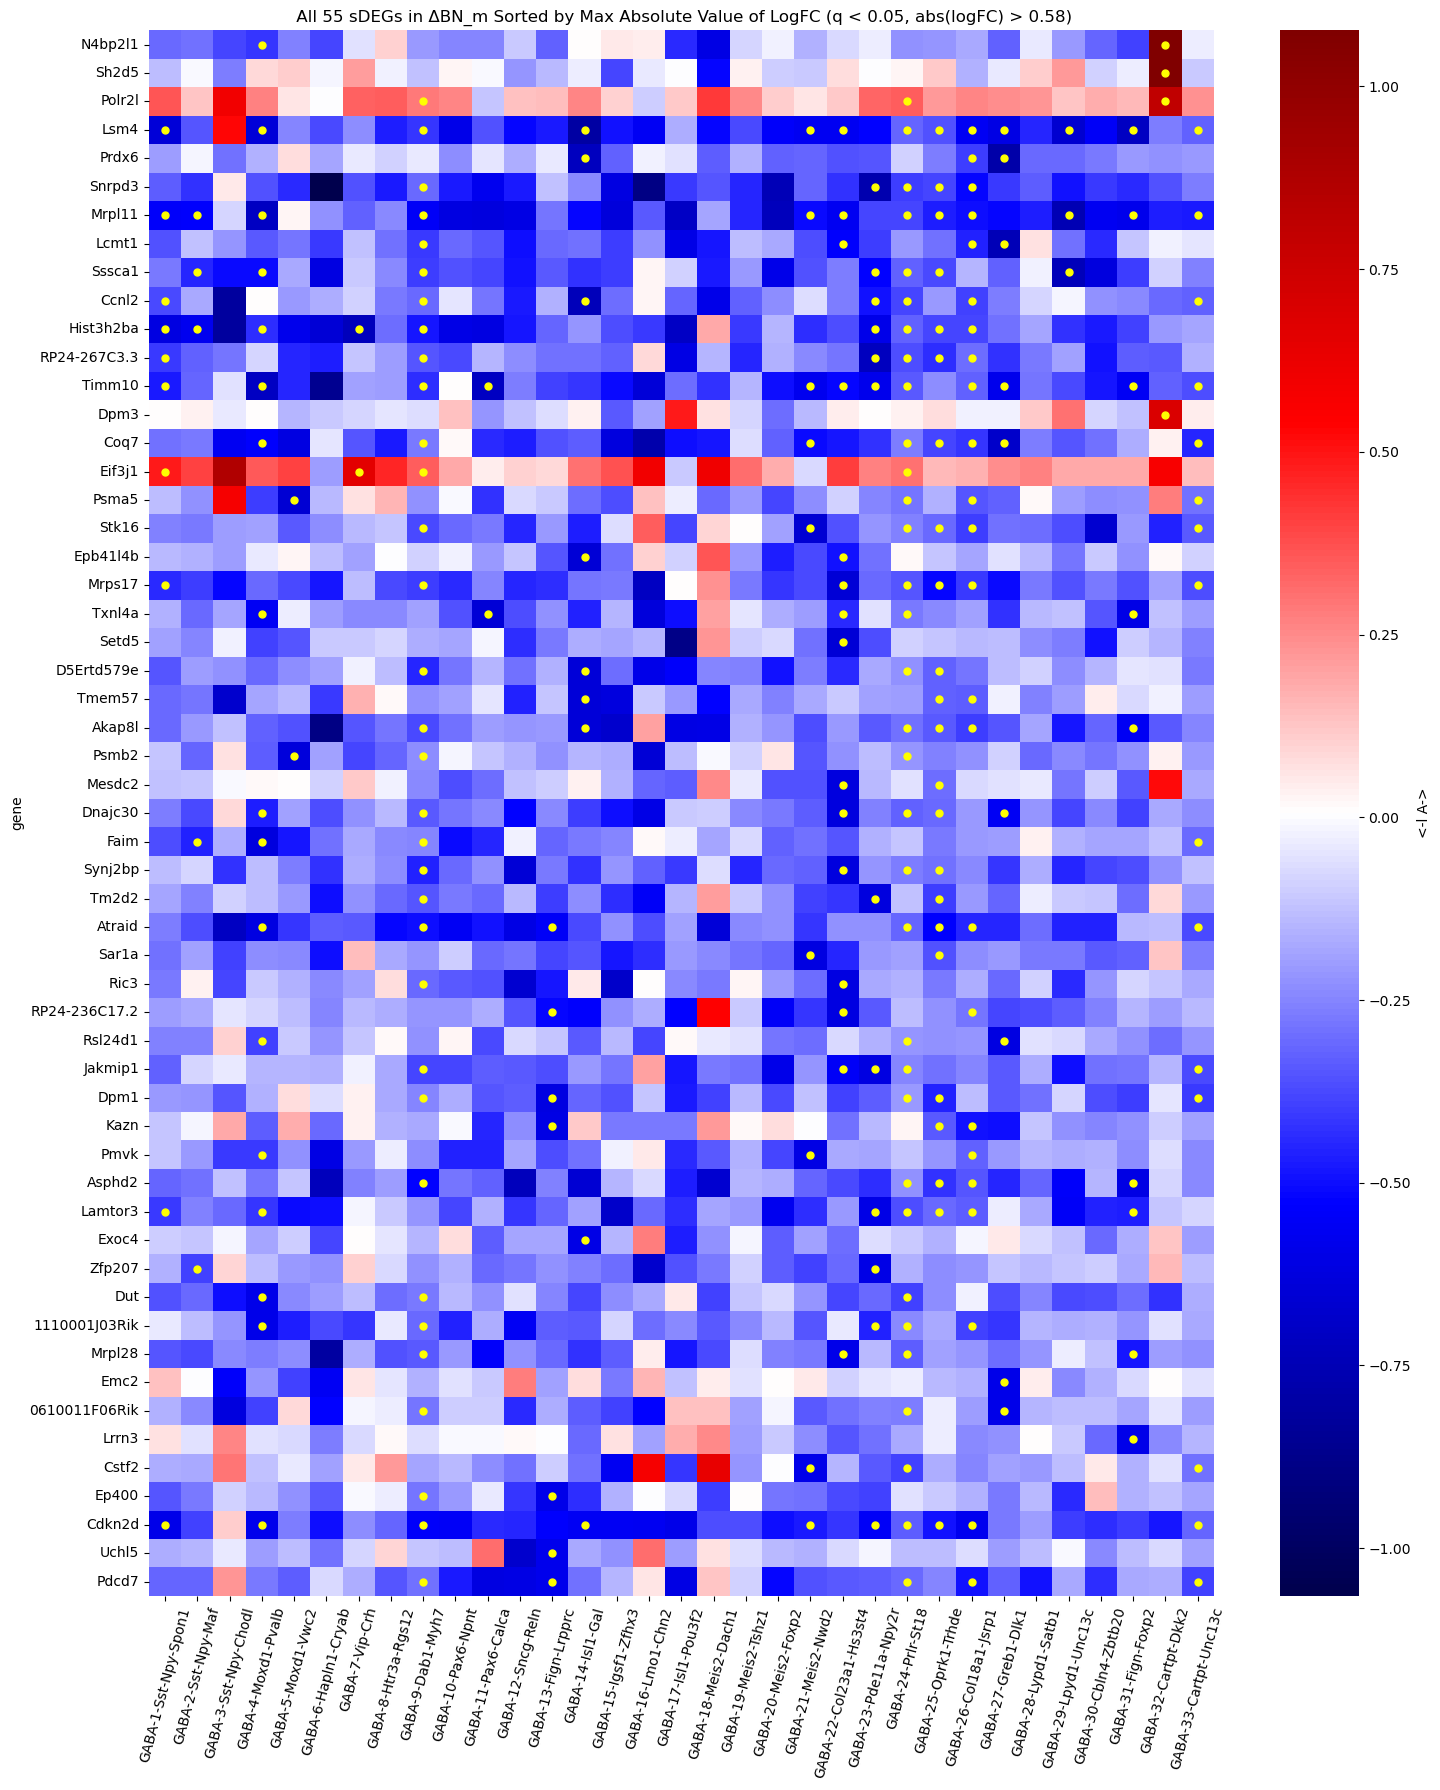

In [604]:
%matplotlib inline
gene_list_fc_p_mask_max_abs_ΔBN_m, gaba_sig_deltas_ΔBN_m_sorted, p_mask_ΔBN_m = sga.p_mask_max_abs(gaba_sig_p_adj_ΔBN_m,gaba_sig_deltas_ΔBN_m)
subset = np.where(gene_list_fc_p_mask_max_abs_ΔBN_m > log_fc)[0][-1:][0]
print (f"subset: {subset}")
sga.plot_sig_gene_heatmap_igi(gaba_sig_deltas_ΔBN_m_sorted,
                              p_mask_ΔBN_m,
                         f' All {subset} sDEGs in ΔBN_m Sorted by Max Absolute Value of LogFC (q < {alpha}, abs(logFC) > {log_fc})',
                        subset,
                        gaba_sig_gene_heatmap_folder,
                        'ΔBN_m' + '_p_mask_max_abs_approach_heatmap_q_dot',
                         savefig = False)

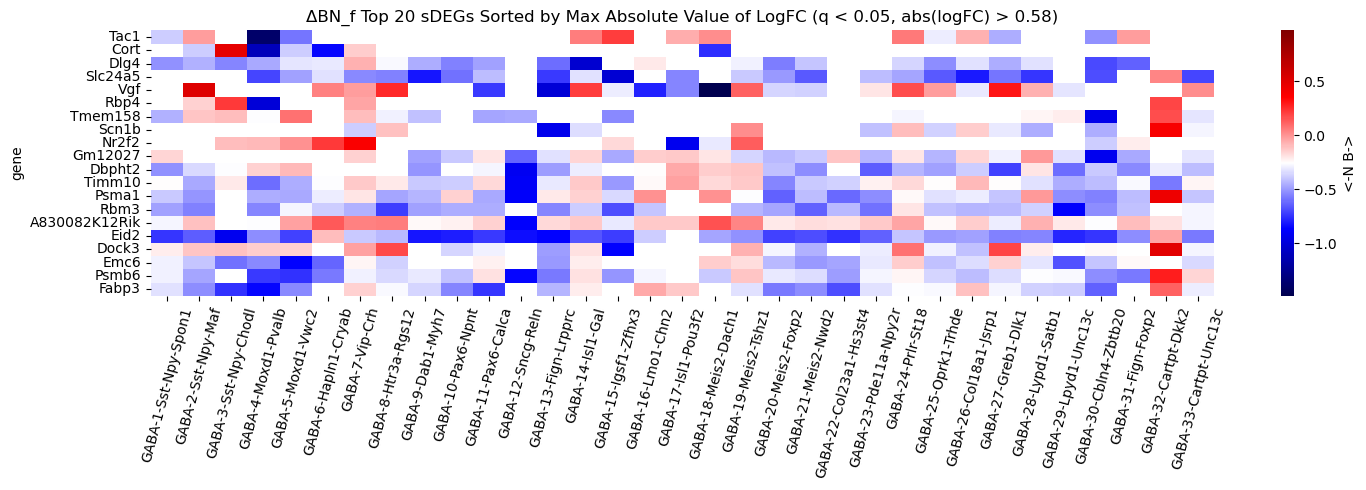

In [456]:
%matplotlib inline
gene_list_fc_p_mask_max_abs_ΔBN_f = sga.p_mask_max_abs(gaba_sig_p_adj_ΔBN_f,gaba_sig_deltas_ΔBN_f)
sga.plot_sig_gene_heatmap_igi(gaba_sig_deltas_ΔBN_f.reindex(index= gene_list_fc_p_mask_max_abs_ΔBN_f.index),
                         'ΔBN_f' + f' Top 20 sDEGs Sorted by Max Absolute Value of LogFC (q < {alpha}, abs(logFC) > {log_fc})',
                        20,
                        gaba_sig_gene_heatmap_folder,
                        'ΔBN_f' + '_p_mask_max_abs_approach_heatmap',
                         savefig = True)

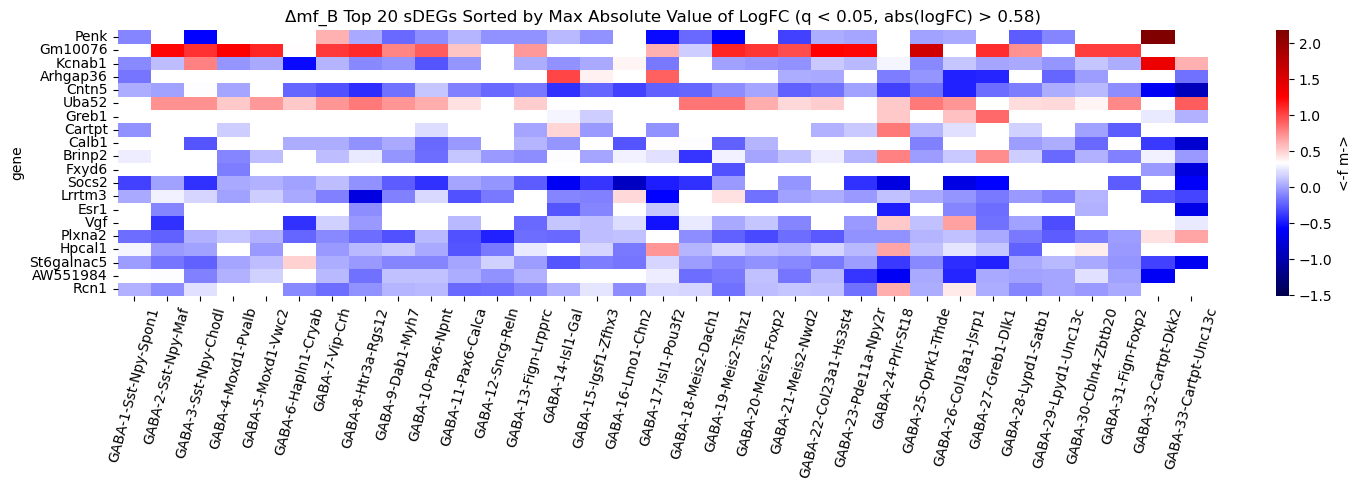

In [457]:
%matplotlib inline
gene_list_fc_p_mask_max_abs_Δmf_B = sga.p_mask_max_abs(gaba_sig_p_adj_Δmf_B,gaba_sig_deltas_Δmf_B)
sga.plot_sig_gene_heatmap_igi(gaba_sig_deltas_Δmf_B.reindex(index= gene_list_fc_p_mask_max_abs_Δmf_B.index),
                         'Δmf_B' + f' Top 20 sDEGs Sorted by Max Absolute Value of LogFC (q < {alpha}, abs(logFC) > {log_fc})',
                        20,
                        gaba_sig_gene_heatmap_folder,
                        'Δmf_B' + '_p_mask_max_abs_approach_heatmap',
                         savefig = True)

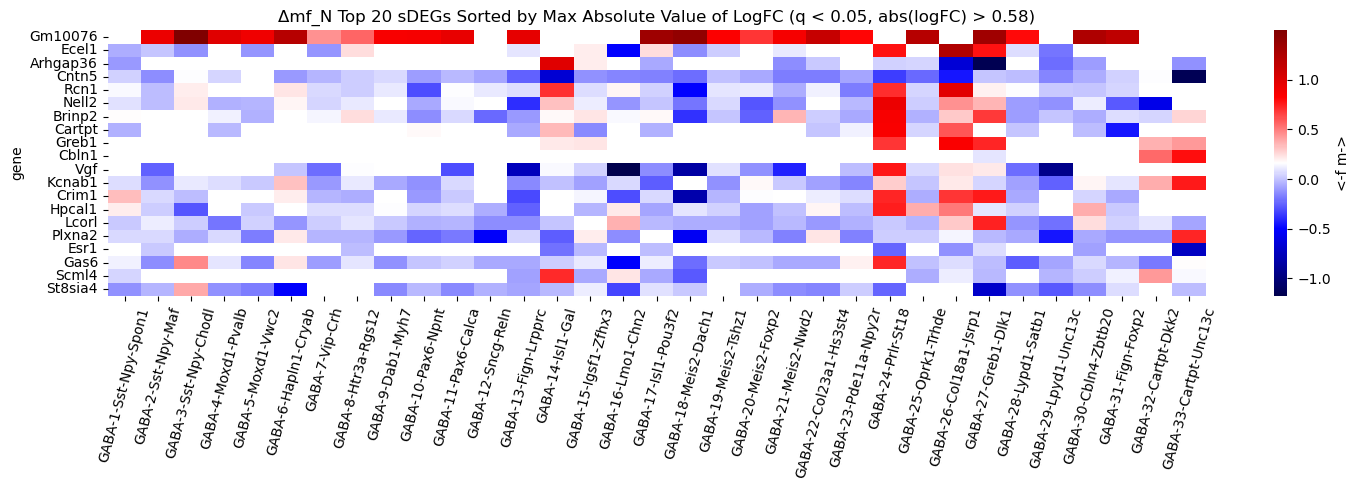

In [458]:
%matplotlib inline
gene_list_fc_p_mask_max_abs_Δmf_N = sga.p_mask_max_abs(gaba_sig_p_adj_Δmf_N,gaba_sig_deltas_Δmf_N)
sga.plot_sig_gene_heatmap_igi(gaba_sig_deltas_Δmf_N.reindex(index= gene_list_fc_p_mask_max_abs_Δmf_N.index),
                         'Δmf_N' + f' Top 20 sDEGs Sorted by Max Absolute Value of LogFC (q < {alpha}, abs(logFC) > {log_fc})',
                        20,
                        gaba_sig_gene_heatmap_folder,
                        'Δmf_N' + '_p_mask_max_abs_approach_heatmap',
                         savefig = True)

In [ ]:
f' Top 20 sDEGs Sorted by Max Absolute Value of LogFC (q < {alpha}, abs(logFC) > {log_fc})'

In [459]:
gaba_sig_gene_heatmap_folder

'/bigdata/isaac/gaba_files/sex_stats/221224_run/sig_gene_heatmaps/'

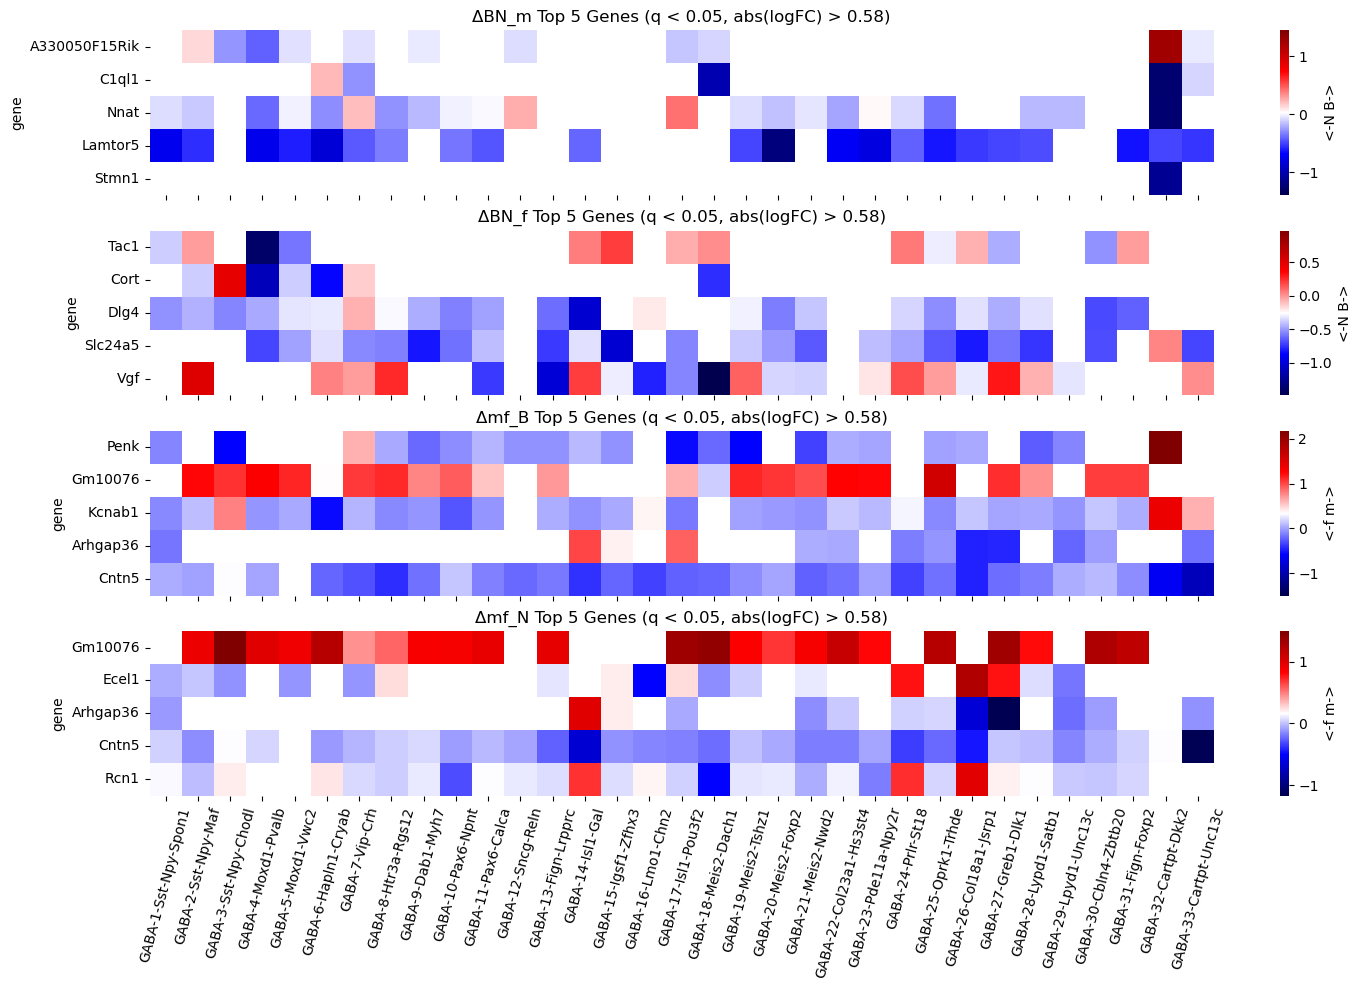

In [460]:
#put onto one plot
subset = 5
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4, sharex = True, figsize = (15,10))

g1 = sns.heatmap(gaba_sig_deltas_ΔBN_m.reindex(index= gene_list_fc_p_mask_max_abs_ΔBN_m.index)[:subset], 
            vmin=gaba_sig_deltas_ΔBN_m.min().min(), 
            vmax=gaba_sig_deltas_ΔBN_m.max().max(),
            cmap='seismic', 
            cbar=True,
            ax = ax1,  
            cbar_kws={'label': '<-' + 'N' + ' ' + 'B' +'->'})
g1.set_xticklabels(gaba_sig_deltas_ΔBN_m.columns.get_level_values(1), rotation = 75) #use (2) for id, (0) for cell type
g1.set_xlabel('')
g1.set_title('ΔBN_m Top 5 Genes' + f' (q < {alpha}, abs(logFC) > {log_fc})')

g2 = sns.heatmap(gaba_sig_deltas_ΔBN_f.reindex(index= gene_list_fc_p_mask_max_abs_ΔBN_f.index)[:subset], 
            vmin=gaba_sig_deltas_ΔBN_f.min().min(), 
            vmax=gaba_sig_deltas_ΔBN_f.max().max(),
            cmap='seismic', 
            cbar=True,
            ax = ax2,  
            cbar_kws={'label': '<-' + 'N' + ' ' + 'B' +'->'})
g2.set_xticklabels(gaba_sig_deltas_ΔBN_f.columns.get_level_values(1), rotation = 75) #use (2) for id, (0) for cell type
g2.set_xlabel('')
g2.set_title('ΔBN_f Top 5 Genes' + f' (q < {alpha}, abs(logFC) > {log_fc})')

g3 = sns.heatmap(gaba_sig_deltas_Δmf_B.reindex(index= gene_list_fc_p_mask_max_abs_Δmf_B.index)[:subset], 
            vmin=gaba_sig_deltas_Δmf_B.min().min(), 
            vmax=gaba_sig_deltas_Δmf_B.max().max(),
            cmap='seismic', 
            cbar=True,
            ax = ax3,  
            cbar_kws={'label': '<-' + 'f' + ' ' + 'm' +'->'})
g3.set_xticklabels(gaba_sig_deltas_Δmf_B.columns.get_level_values(1), rotation = 75) #use (2) for id, (0) for cell type
g3.set_xlabel('')
g3.set_title('Δmf_B Top 5 Genes'  + f' (q < {alpha}, abs(logFC) > {log_fc})')

g4 = sns.heatmap(gaba_sig_deltas_Δmf_N.reindex(index= gene_list_fc_p_mask_max_abs_Δmf_N.index)[:subset], 
            vmin=gaba_sig_deltas_Δmf_N.min().min(), 
            vmax=gaba_sig_deltas_Δmf_N.max().max(),
            cmap='seismic', 
            cbar=True,
            ax= ax4,  
            cbar_kws={'label': '<-' + 'f' + ' ' + 'm' +'->'})
g4.set_xticklabels(gaba_sig_deltas_Δmf_N.columns.get_level_values(1), rotation = 75) #use (2) for id, (0) for cell type
g4.set_xlabel('')
g4.set_title('Δmf_N Top 5 Genes' + f' (q < {alpha}, abs(logFC) > {log_fc})')

plt.tight_layout()
plt.savefig(gaba_sig_gene_heatmap_folder + 'all_groups_p_mask_max_abs_approach_heatmap.pdf')
plt.show()

In [320]:
np.arange(1,len(gaba_sig_deltas_Δmf_N.columns.get_level_values(1))+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [610]:
gaba_sig_deltas

delta                                \
cluster_fn    GABA-1-Sst-Npy-Spon1                                 
test                         ΔBN_m     ΔBN_f     Δmf_B     Δmf_N   
gene                                                               
0610011F06Rik            -0.156479 -0.296119  0.130410 -0.009230   
0610012G03Rik                  NaN       NaN       NaN       NaN   
1110001J03Rik            -0.044125 -0.131509  0.026483 -0.060901   
1110008F13Rik            -0.432203 -0.041551 -0.169406  0.221246   
1110065P20Rik            -0.396915 -0.318347 -0.140659 -0.062091   
...                            ...       ...       ...       ...   
Zc2hc1a                  -0.392097 -0.171227 -0.002130  0.218739   
Zdbf2                    -0.227397 -0.144675 -0.035338  0.047383   
Zfp207                   -0.155437 -0.442193  0.096890 -0.189865   
Zfp638                   -0.408996 -0.373403 -0.007330  0.028262   
Zmynd8                         NaN       NaN       NaN       NaN   

                                                                \
cluster_fn    GABA-2-Sst-Npy-Maf                                 
test                       ΔBN_m     ΔBN_f     Δmf_B     Δmf_N   
gene                                                             
0610011F06Rik          -0.237285 -0.197111 -0.043576 -0.003403   
0610012G03Rik                NaN       NaN       NaN       NaN   
1110001J03Rik          -0.132729 -0.201087 -0.284612 -0.352970   
1110008F13Rik          -0.207618 -0.391373  0.130151 -0.053604   
1110065P20Rik          -0.540372 -0.239234 -0.051479  0.249658   
...                          ...       ...       ...       ...   
Zc2hc1a                -0.196441 -0.198041 -0.063817 -0.065417   
Zdbf2                  -0.389728 -0.325918 -0.317011 -0.253201   
Zfp207                 -0.391765 -0.207513 -0.064066  0.120186   
Zfp638                 -0.258308 -0.353904  0.043904 -0.051693   
Zmynd8                       NaN       NaN       NaN       NaN   

                                              ...                     \
cluster_fn    GABA-3-Sst-Npy-Chodl            ... GABA-31-Fign-Foxp2   
test                         ΔBN_m     ΔBN_f  ...              Δmf_B   
gene                                          ...                      
0610011F06Rik            -0.622657 -0.453885  ...          -0.058936   
0610012G03Rik                  NaN       NaN  ...                NaN   
1110001J03Rik            -0.212999 -0.346684  ...          -0.014913   
1110008F13Rik            -0.251236 -0.518881  ...          -0.139902   
1110065P20Rik                  NaN       NaN  ...           0.037076   
...                            ...       ...  ...                ...   
Zc2hc1a                  -0.311546 -0.476942  ...          -0.022652   
Zdbf2                    -0.053667 -0.393156  ...          -0.329405   
Zfp207                    0.092231 -0.264160  ...           0.111649   
Zfp638                   -0.384570 -0.257992  ...          -0.081053   
Zmynd8                         NaN       NaN  ...                NaN   

                                                                           \
cluster_fn              GABA-32-Cartpt-Dkk2                                 
test              Δmf_N               ΔBN_m     ΔBN_f     Δmf_B     Δmf_N   
gene                                                                        
0610011F06Rik -0.133485           -0.051830 -0.341425  0.126136 -0.163459   
0610012G03Rik       NaN                 NaN       NaN       NaN       NaN   
1110001J03Rik -0.094968           -0.059664 -0.059291 -0.058098 -0.057725   
1110008F13Rik -0.243318           -0.236639 -0.083566  0.144297  0.297370   
1110065P20Rik  0.067361                 NaN       NaN       NaN       NaN   
...                 ...                 ...       ...       ...       ...   
Zc2hc1a        0.103876           -0.252709 -0.039527  0.132441  0.345622   
Zdbf2         -0.333397                 NaN       NaN       NaN       NaN   
Zfp207      

In [504]:
np.unique(gaba_sig_genes.loc[:,'cluster_fn'])

array(['GABA-1-Sst-Npy-Spon1', 'GABA-10-Pax6-Npnt', 'GABA-11-Pax6-Calca',
       'GABA-12-Sncg-Reln', 'GABA-13-Fign-Lrpprc', 'GABA-14-Isl1-Gal',
       'GABA-15-Igsf1-Zfhx3', 'GABA-17-Isl1-Pou3f2',
       'GABA-19-Meis2-Tshz1', 'GABA-2-Sst-Npy-Maf', 'GABA-20-Meis2-Foxp2',
       'GABA-21-Meis2-Nwd2', 'GABA-22-Col23a1-Hs3st4',
       'GABA-23-Pde11a-Npy2r', 'GABA-24-Prlr-St18', 'GABA-25-Oprk1-Trhde',
       'GABA-26-Col18a1-Jsrp1', 'GABA-27-Greb1-Dlk1',
       'GABA-28-Lypd1-Satb1', 'GABA-29-Lpyd1-Unc13c',
       'GABA-30-Cbln4-Zbtb20', 'GABA-31-Fign-Foxp2',
       'GABA-32-Cartpt-Dkk2', 'GABA-33-Cartpt-Unc13c',
       'GABA-4-Moxd1-Pvalb', 'GABA-5-Moxd1-Vwc2', 'GABA-7-Vip-Crh',
       'GABA-8-Htr3a-Rgs12', 'GABA-9-Dab1-Myh7'], dtype=object)

In [503]:
len(gaba_fn)

33

In [784]:
gaba_sig_genes

,cluster_fn,test,gene,delta,p_adj
1047,GABA-1-Sst-Npy-Spon1,ΔBN_m,Cct5,-0.634634,3.026165e-04
1110,GABA-1-Sst-Npy-Spon1,ΔBN_m,Cdkn2d,-0.590485,5.038371e-04
1169,GABA-1-Sst-Npy-Spon1,ΔBN_m,Chchd4,-0.652496,2.505501e-04
1696,GABA-1-Sst-Npy-Spon1,ΔBN_m,Dlg4,-0.617750,1.060355e-03
2541,GABA-1-Sst-Npy-Spon1,ΔBN_m,Gmps,-0.587455,1.856598e-03
...,...,...,...,...,...
919034,GABA-33-Cartpt-Unc13c,Δmf_N,Odc1,0.591706,1.221922e-04
919407,GABA-33-Cartpt-Unc13c,Δmf_N,Plxna2,0.732233,6.846000e-07
920675,GABA-33-Cartpt-Unc13c,Δmf_N,Sox5,0.668074,3.497000e-07
920748,GABA-33-Cartpt-Unc13c,Δmf_N,Srrm4,0.625103,7.096000e-07


In [841]:
#ranking most dimorphic cell types by counting number of 
#stat significant genes in each cell type
cluster_fn_list = []
num_genes_per_ct = []
ΔBN_m = []
ΔBN_f = []
Δmf_B = []
Δmf_N = []
for x in np.unique(gaba_sig_genes['cluster_fn']):
    subset = gaba_sig_genes.iloc[np.where(gaba_sig_genes['cluster_fn']==x)[0]]
    g = subset.shape[0]
    #print (subset.shape)
    #print (subset.loc[subset.loc[:,'test']=='ΔBN_m',:].shape)
    ΔBN_m.append(subset.loc[subset.loc[:,'test']=='ΔBN_m',:].shape[0])
    ΔBN_f.append(subset.loc[subset.loc[:,'test']=='ΔBN_f',:].shape[0])
    Δmf_B.append(subset.loc[subset.loc[:,'test']=='Δmf_B',:].shape[0])
    Δmf_N.append(subset.loc[subset.loc[:,'test']=='Δmf_N',:].shape[0])
    num_genes_per_ct.append(g)
    cluster_fn_list.append(x)
    

In [842]:
_,ind = np.unique(gaba_sig_deltas.columns.get_level_values(1),return_index=True)
dd_dlr_fn_order = np.array(gaba_sig_deltas.columns.get_level_values(1)[np.sort(ind)])

In [843]:
dd_dlr_fn_order

array(['GABA-1-Sst-Npy-Spon1', 'GABA-2-Sst-Npy-Maf',
       'GABA-3-Sst-Npy-Chodl', 'GABA-4-Moxd1-Pvalb', 'GABA-5-Moxd1-Vwc2',
       'GABA-6-Hapln1-Cryab', 'GABA-7-Vip-Crh', 'GABA-8-Htr3a-Rgs12',
       'GABA-9-Dab1-Myh7', 'GABA-10-Pax6-Npnt', 'GABA-11-Pax6-Calca',
       'GABA-12-Sncg-Reln', 'GABA-13-Fign-Lrpprc', 'GABA-14-Isl1-Gal',
       'GABA-15-Igsf1-Zfhx3', 'GABA-16-Lmo1-Chn2', 'GABA-17-Isl1-Pou3f2',
       'GABA-18-Meis2-Dach1', 'GABA-19-Meis2-Tshz1',
       'GABA-20-Meis2-Foxp2', 'GABA-21-Meis2-Nwd2',
       'GABA-22-Col23a1-Hs3st4', 'GABA-23-Pde11a-Npy2r',
       'GABA-24-Prlr-St18', 'GABA-25-Oprk1-Trhde',
       'GABA-26-Col18a1-Jsrp1', 'GABA-27-Greb1-Dlk1',
       'GABA-28-Lypd1-Satb1', 'GABA-29-Lpyd1-Unc13c',
       'GABA-30-Cbln4-Zbtb20', 'GABA-31-Fign-Foxp2',
       'GABA-32-Cartpt-Dkk2', 'GABA-33-Cartpt-Unc13c'], dtype=object)

In [787]:
len(num_genes_per_ct)

29

In [788]:
len(cluster_fn_list)

29

In [844]:
dimorph_cell_types_df = pd.DataFrame()
dimorph_cell_types_df['cluster_fn'] = cluster_fn_list
dimorph_cell_types_df['gene_count'] = num_genes_per_ct
dimorph_cell_types_df['ΔBN_m'] = ΔBN_m
dimorph_cell_types_df['ΔBN_f'] = ΔBN_f 
dimorph_cell_types_df['Δmf_B'] = Δmf_B 
dimorph_cell_types_df['Δmf_N'] = Δmf_N 

In [845]:
dimorph_cell_types_df

,cluster_fn,gene_count,ΔBN_m,ΔBN_f,Δmf_B,Δmf_N
0,GABA-1-Sst-Npy-Spon1,16,13,3,0,0
1,GABA-10-Pax6-Npnt,14,3,11,0,0
2,GABA-11-Pax6-Calca,18,15,3,0,0
3,GABA-12-Sncg-Reln,98,0,98,0,0
4,GABA-13-Fign-Lrpprc,121,64,56,0,1
5,GABA-14-Isl1-Gal,30,22,6,1,1
6,GABA-15-Igsf1-Zfhx3,7,0,7,0,0
7,GABA-17-Isl1-Pou3f2,12,0,11,0,1
8,GABA-19-Meis2-Tshz1,8,4,1,2,1
9,GABA-2-Sst-Npy-Maf,32,9,20,2,1


In [791]:
dimorph_cell_types_df = dimorph_cell_types_df.set_index('cluster_fn')

In [746]:
np.all(dd_dlr_fn_order == gaba_fn)

True

In [525]:
np.flip(dd_dlr_fn_order)

array(['GABA-33-Cartpt-Unc13c', 'GABA-32-Cartpt-Dkk2',
       'GABA-31-Fign-Foxp2', 'GABA-30-Cbln4-Zbtb20',
       'GABA-29-Lpyd1-Unc13c', 'GABA-28-Lypd1-Satb1',
       'GABA-27-Greb1-Dlk1', 'GABA-26-Col18a1-Jsrp1',
       'GABA-25-Oprk1-Trhde', 'GABA-24-Prlr-St18', 'GABA-23-Pde11a-Npy2r',
       'GABA-22-Col23a1-Hs3st4', 'GABA-21-Meis2-Nwd2',
       'GABA-20-Meis2-Foxp2', 'GABA-19-Meis2-Tshz1',
       'GABA-18-Meis2-Dach1', 'GABA-17-Isl1-Pou3f2', 'GABA-16-Lmo1-Chn2',
       'GABA-15-Igsf1-Zfhx3', 'GABA-14-Isl1-Gal', 'GABA-13-Fign-Lrpprc',
       'GABA-12-Sncg-Reln', 'GABA-11-Pax6-Calca', 'GABA-10-Pax6-Npnt',
       'GABA-9-Dab1-Myh7', 'GABA-8-Htr3a-Rgs12', 'GABA-7-Vip-Crh',
       'GABA-6-Hapln1-Cryab', 'GABA-5-Moxd1-Vwc2', 'GABA-4-Moxd1-Pvalb',
       'GABA-3-Sst-Npy-Chodl', 'GABA-2-Sst-Npy-Maf',
       'GABA-1-Sst-Npy-Spon1'], dtype=object)

In [792]:
dimorph_cell_types_df_sorted = dimorph_cell_types_df.reindex(index=np.flip(dd_dlr_fn_order))
dimorph_cell_types_df_sorted

,gene_count,ΔBN_m,ΔBN_f,Δmf_B,Δmf_N
cluster_fn,,,,,
GABA-33-Cartpt-Unc13c,81.0,0.0,12.0,33.0,36.0
GABA-32-Cartpt-Dkk2,81.0,75.0,0.0,6.0,0.0
GABA-31-Fign-Foxp2,123.0,90.0,27.0,3.0,3.0
GABA-30-Cbln4-Zbtb20,132.0,6.0,123.0,0.0,3.0
GABA-29-Lpyd1-Unc13c,66.0,21.0,45.0,0.0,0.0
GABA-28-Lypd1-Satb1,6.0,0.0,6.0,0.0,0.0
GABA-27-Greb1-Dlk1,195.0,156.0,6.0,6.0,27.0
GABA-26-Col18a1-Jsrp1,63.0,27.0,6.0,9.0,21.0
GABA-25-Oprk1-Trhde,108.0,90.0,9.0,6.0,3.0


In [ ]:
#dimorph_cell_types_df_sorted = dimorph_cell_types_df.sort_values(by = 'gene_count', ascending = False)

In [ ]:
#dimorph_cell_types_df_sorted = dimorph_cell_types_df_sorted.set_index('cluster_fn')

In [793]:
dimorph_cell_types_df_sorted.insert(5,'ct_size', None)

In [794]:
ct_size_vector = []
for ct in dimorph_cell_types_df_sorted.index:
    ct_size = gaba_metadata_df_dlr.loc[:,gaba_metadata_df_dlr.loc['full_name',:]==ct].shape[1]
    dimorph_cell_types_df_sorted.loc[ct,'ct_size'] = ct_size
    #print (ct, ct_size)

In [795]:
dimorph_cell_types_df_sorted

,gene_count,ΔBN_m,ΔBN_f,Δmf_B,Δmf_N,ct_size
cluster_fn,,,,,,
GABA-33-Cartpt-Unc13c,81.0,0.0,12.0,33.0,36.0,458
GABA-32-Cartpt-Dkk2,81.0,75.0,0.0,6.0,0.0,106
GABA-31-Fign-Foxp2,123.0,90.0,27.0,3.0,3.0,306
GABA-30-Cbln4-Zbtb20,132.0,6.0,123.0,0.0,3.0,184
GABA-29-Lpyd1-Unc13c,66.0,21.0,45.0,0.0,0.0,278
GABA-28-Lypd1-Satb1,6.0,0.0,6.0,0.0,0.0,254
GABA-27-Greb1-Dlk1,195.0,156.0,6.0,6.0,27.0,194
GABA-26-Col18a1-Jsrp1,63.0,27.0,6.0,9.0,21.0,391
GABA-25-Oprk1-Trhde,108.0,90.0,9.0,6.0,3.0,500


In [800]:
gaba_sig_genes.loc[gaba_sig_genes.loc[:,'cluster_fn'] == 'GABA-33-Cartpt-Unc13c',:]	

,cluster_fn,test,gene,delta,p_adj
903162,GABA-33-Cartpt-Unc13c,ΔBN_f,Grid2,-0.601730,1.237702e-03
903981,GABA-33-Cartpt-Unc13c,ΔBN_f,Matk,-0.633133,1.562591e-03
906031,GABA-33-Cartpt-Unc13c,ΔBN_f,Slc24a5,-0.701629,2.859900e-06
906261,GABA-33-Cartpt-Unc13c,ΔBN_f,Socs2,0.615098,1.676460e-05
908068,GABA-33-Cartpt-Unc13c,Δmf_B,Alcam,-0.599093,2.191070e-05
908624,GABA-33-Cartpt-Unc13c,Δmf_B,Calb1,-0.819839,1.360000e-08
909002,GABA-33-Cartpt-Unc13c,Δmf_B,Cntn5,-0.943630,9.000000e-10
909726,GABA-33-Cartpt-Unc13c,Δmf_B,Esr1,-0.698660,6.460000e-08
910073,GABA-33-Cartpt-Unc13c,Δmf_B,Fxyd6,-0.750280,1.363100e-06
910768,GABA-33-Cartpt-Unc13c,Δmf_B,Kcnab1,0.624904,2.841120e-05


In [511]:
gaba_sig_gene_heatmap_folder

'/bigdata/isaac/gaba_files/sex_stats/221224_run/sig_gene_heatmaps/'

In [696]:
#ct_bar_plots_folder = '/bigdata/isaac/gaba_files/sex_stats/191224_run/ct_bar_plots/'
ct_bar_plots_folder = '/bigdata/isaac/gaba_files/sex_stats/261224_run/ct_bar_plots/'


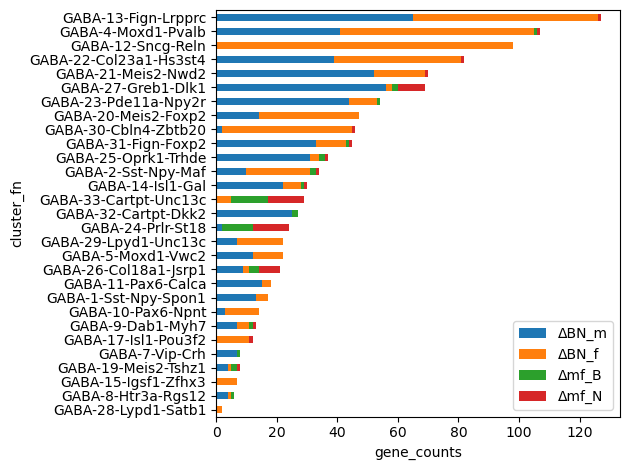

In [697]:
ax = dimorph_cell_types_df_sorted.sort_values(by='gene_count').iloc[:,1:5].dropna().plot.barh(stacked=True)
ax.set_xlabel('gene_counts')
plt.tight_layout()
plt.savefig(ct_bar_plots_folder + 'ranked_cts_all_groups.pdf', transparent = True)
plt.show()

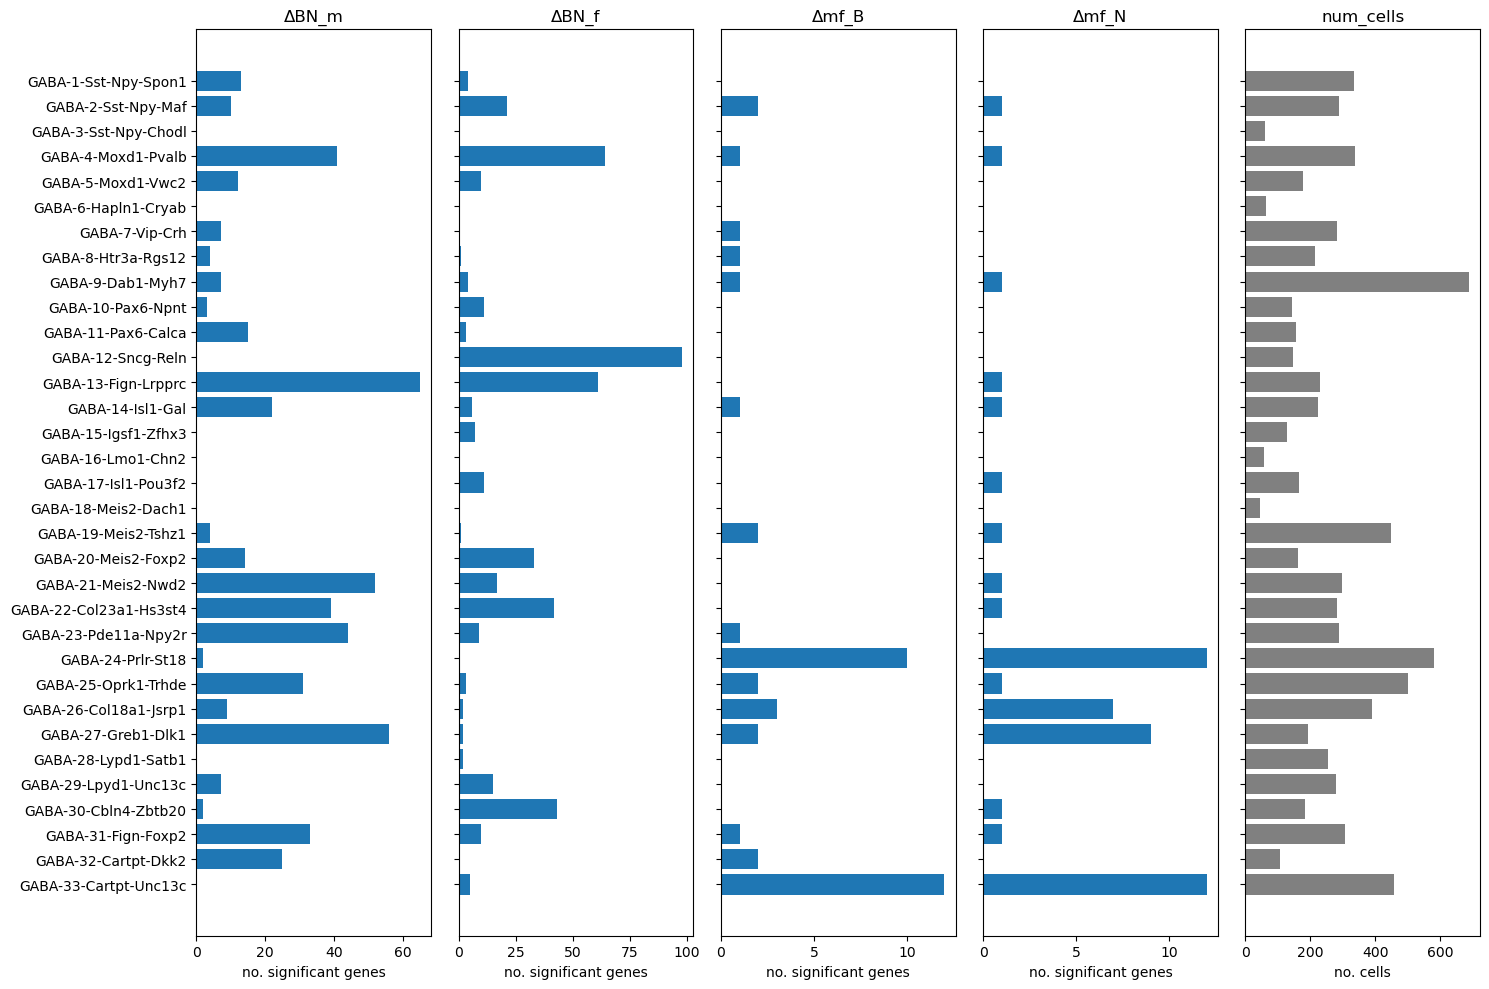

In [698]:
#create a horizonatly stacked multiplot, using order of stacked
fig,axs = plt.subplots(1,5, sharey=True, figsize = (15,10))
axs[0].barh(y = dimorph_cell_types_df_sorted.index, width=dimorph_cell_types_df_sorted.loc[:,'ΔBN_m'])
axs[1].barh(y = dimorph_cell_types_df_sorted.index, width=dimorph_cell_types_df_sorted.loc[:,'ΔBN_f'])
axs[2].barh(y = dimorph_cell_types_df_sorted.index, width=dimorph_cell_types_df_sorted.loc[:,'Δmf_B'])
axs[3].barh(y = dimorph_cell_types_df_sorted.index, width=dimorph_cell_types_df_sorted.loc[:,'Δmf_N'])
axs[4].barh(y = dimorph_cell_types_df_sorted.index, width = dimorph_cell_types_df_sorted.loc[:,'ct_size'], color = 'gray')
axs[0].set_title('ΔBN_m')
axs[0].set_xlabel('no. significant genes')
axs[1].set_title('ΔBN_f')
axs[1].set_xlabel('no. significant genes')
axs[2].set_title('Δmf_B')
axs[2].set_xlabel('no. significant genes')
axs[3].set_title('Δmf_N')
axs[3].set_xlabel('no. significant genes')
axs[4].set_title('num_cells')
axs[4].set_xlabel('no. cells')

plt.tight_layout()
# Apply the same ticks and labels to the last two plots
#for ax in axes[2:]:
    #ax.set_xticks(tick_positions)
    #ax.set_xticklabels(tick_labels)
plt.savefig(ct_bar_plots_folder + 'ranked_cts_num_cells_horizontal.pdf')
plt.show()

In [848]:
#run using run_sig_genes.py
gaba_all_genes_folder = '/bigdata/isaac/gaba_files/sex_stats/271224_run/volcano_plots/'
gaba_sex_stats_folder = '/bigdata/isaac/gaba_files/sex_stats/271224_run/'
gaba_sig_gene_heatmap_folder = '/bigdata/isaac/gaba_files/sex_stats/271224_run/sig_gene_heatmaps/'
gaba_ct_bar_plots_folder = '/bigdata/isaac/gaba_files/sex_stats/271224_run/ct_bar_plots/'

gaba_sig_deltas, gaba_sig_p_adj, gaba_dimorph_cell_types_df_sorted = rsg.run_sig_genes(gaba_all_genes_folder, gaba_sex_stats_folder, gaba_sig_gene_heatmap_folder, gaba_ct_bar_plots_folder, cell_class='gaba', log_fc = np.log2(1.5),alpha = 0.05, savefig = True, write_to_file = True)


/home/isaac/analysis/scRNA-seq/run_sig_genes.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fn = np.array(metadata_df_dlr.loc['full_name'][np.sort(idx)])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [717]:
gaba_sig_deltas.iloc[0,14]

-0.0585544011999999

In [718]:
gaba_sig_deltas_tmp.iloc[0,14]

-0.058554401199999905

In [716]:
np.where(gaba_sig_deltas != gaba_sig_deltas_tmp)

(array([  0,   0,   0, ..., 621, 621, 621]),
 array([ 14,  16,  41, ..., 129, 130, 131]))

In [849]:
gaba_dimorph_cell_types_df_sorted

,gene_count,ΔBN_m,ΔBN_f,Δmf_B,Δmf_N,ct_size
cluster_fn,,,,,,
GABA-33-Cartpt-Unc13c,27.0,0.0,4.0,11.0,12.0,458
GABA-32-Cartpt-Dkk2,27.0,25.0,0.0,2.0,0.0,106
GABA-31-Fign-Foxp2,41.0,30.0,9.0,1.0,1.0,306
GABA-30-Cbln4-Zbtb20,44.0,2.0,41.0,0.0,1.0,184
GABA-29-Lpyd1-Unc13c,22.0,7.0,15.0,0.0,0.0,278
GABA-28-Lypd1-Satb1,2.0,0.0,2.0,0.0,0.0,254
GABA-27-Greb1-Dlk1,65.0,52.0,2.0,2.0,9.0,194
GABA-26-Col18a1-Jsrp1,21.0,9.0,2.0,3.0,7.0,391
GABA-25-Oprk1-Trhde,36.0,30.0,3.0,2.0,1.0,500


In [866]:
#investigate gene composition of GABA-33-Cartpt-Unc13c
max_fc_sorted, sig_deltas_sorted, mask_sorted = sga.p_mask_max_abs(gaba_sig_p_adj.loc[:,gaba_sig_p_adj.columns.get_level_values(1) == 'GABA-33-Cartpt-Unc13c'],
                                                                   gaba_sig_deltas.loc[:,gaba_sig_deltas.columns.get_level_values(1) == 'GABA-33-Cartpt-Unc13c'])
subset = len(np.where(max_fc_sorted>log_fc)[0])
#subset = ['Cntn5','Esr1','Kcnab1','Plxnab2']
sga.plot_sig_gene_heatmap_sct(sig_deltas_sorted,
                              mask_sorted, 
                              'GABA-33-Cartpt-Unc13c', 
                              subset,                        
                              gaba_sig_gene_heatmap_folder,
                              'GABA-33-Cartpt-Unc13c_p_mask_max_abs_approach_heatmap_q_dot_d_halo',
                            savefig = True)

<IPython.core.display.Javascript object>

/home/isaac/analysis/scRNA-seq/sig_gene_analysis.py:234: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  #fix x tick cut off when saving fig


In [867]:
#investigate gene composition of GABA-24-Prlr-St18
cluster_fn = 'GABA-24-Prlr-St18'
max_fc_sorted, sig_deltas_sorted, mask_sorted = sga.p_mask_max_abs(gaba_sig_p_adj.loc[:,gaba_sig_p_adj.columns.get_level_values(1) == cluster_fn],
                                                                   gaba_sig_deltas.loc[:,gaba_sig_deltas.columns.get_level_values(1) == cluster_fn])
subset = len(np.where(max_fc_sorted>log_fc)[0])
sga.plot_sig_gene_heatmap_sct(sig_deltas_sorted,
                              mask_sorted, 
                              cluster_fn, 
                              subset,                        
                              gaba_sig_gene_heatmap_folder,
                              cluster_fn + '_p_mask_max_abs_approach_heatmap_q_dot_d_halo',
                            savefig = True)

<IPython.core.display.Javascript object>

/home/isaac/analysis/scRNA-seq/sig_gene_analysis.py:234: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  #fix x tick cut off when saving fig


In [868]:

cluster_fn = 'GABA-27-Greb1-Dlk1'
max_fc_sorted, sig_deltas_sorted, mask_sorted = sga.p_mask_max_abs(gaba_sig_p_adj.loc[:,gaba_sig_p_adj.columns.get_level_values(1) == cluster_fn],
                                                                   gaba_sig_deltas.loc[:,gaba_sig_deltas.columns.get_level_values(1) == cluster_fn])
subset = len(np.where(max_fc_sorted>log_fc)[0])
sga.plot_sig_gene_heatmap_sct(sig_deltas_sorted,
                              mask_sorted, 
                              cluster_fn, 
                              subset,                        
                              gaba_sig_gene_heatmap_folder,
                              cluster_fn + '_p_mask_max_abs_approach_heatmap_q_dot_d_halo',
                            savefig = True)

<IPython.core.display.Javascript object>

/home/isaac/analysis/scRNA-seq/sig_gene_analysis.py:234: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  #fix x tick cut off when saving fig


In [869]:
cluster_fn = 'GABA-26-Col18a1-Jsrp1'
max_fc_sorted, sig_deltas_sorted, mask_sorted = sga.p_mask_max_abs(gaba_sig_p_adj.loc[:,gaba_sig_p_adj.columns.get_level_values(1) == cluster_fn],
                                                                   gaba_sig_deltas.loc[:,gaba_sig_deltas.columns.get_level_values(1) == cluster_fn])
subset = len(np.where(max_fc_sorted>log_fc)[0])
sga.plot_sig_gene_heatmap_sct(sig_deltas_sorted,
                              mask_sorted, 
                              cluster_fn, 
                              subset,                        
                              gaba_sig_gene_heatmap_folder,
                              cluster_fn + '_p_mask_max_abs_approach_heatmap_q_dot_d_halo',
                            savefig = True)

<IPython.core.display.Javascript object>

/home/isaac/analysis/scRNA-seq/sig_gene_analysis.py:234: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  #fix x tick cut off when saving fig


In [662]:
gaba_sig_genes.loc[gaba_sig_genes.loc[:,'cluster_fn'] == 'GABA-33-Cartpt-Unc13c',:]

,cluster_fn,test,gene,delta,p_adj
902399,GABA-33-Cartpt-Unc13c,ΔBN_f,Eid2,-0.580005,3.163138e-04
903162,GABA-33-Cartpt-Unc13c,ΔBN_f,Grid2,-0.601730,1.237702e-03
903981,GABA-33-Cartpt-Unc13c,ΔBN_f,Matk,-0.633133,1.562591e-03
906031,GABA-33-Cartpt-Unc13c,ΔBN_f,Slc24a5,-0.701629,2.859900e-06
906261,GABA-33-Cartpt-Unc13c,ΔBN_f,Socs2,0.615098,1.676460e-05
908068,GABA-33-Cartpt-Unc13c,Δmf_B,Alcam,-0.599093,2.191070e-05
908624,GABA-33-Cartpt-Unc13c,Δmf_B,Calb1,-0.819839,1.360000e-08
909002,GABA-33-Cartpt-Unc13c,Δmf_B,Cntn5,-0.943630,9.000000e-10
909726,GABA-33-Cartpt-Unc13c,Δmf_B,Esr1,-0.698660,6.460000e-08
910073,GABA-33-Cartpt-Unc13c,Δmf_B,Fxyd6,-0.750280,1.363100e-06


In [250]:
cts_ind_changed_N2B = pd.DataFrame(index = dimorph_cell_types_df.loc[:,'cluster_fn'], columns=['ind_change_N2B'])

In [251]:
cts_ind_changed_N2B


,ind_change_N2B
cluster_fn,
GABA-1-Sst-Npy-Spon1,NaN
GABA-10-Pax6-Npnt,NaN
GABA-11-Pax6-Calca,NaN
GABA-12-Sncg-Reln,NaN
GABA-13-Fign-Lrpprc,NaN
GABA-14-Isl1-Gal,NaN
GABA-15-Igsf1-Zfhx3,NaN
GABA-17-Isl1-Pou3f2,NaN
GABA-19-Meis2-Tshz1,NaN


In [252]:
cts_ind_changed_N2B.loc['GABA-1-Sst-Npy-Spon1',:]

ind_change_N2B    NaN
Name: GABA-1-Sst-Npy-Spon1, dtype: object

In [241]:
Δmf_N_tgs

['GABA-33-Cartpt-Unc13c',
 'GABA-24-Prlr-St18',
 'GABA-26-Col18a1-Jsrp1',
 'GABA-27-Greb1-Dlk1',
 'GABA-14-Isl1-Gal',
 'GABA-1-Sst-Npy-Spon1',
 'GABA-4-Moxd1-Pvalb',
 'GABA-22-Col23a1-Hs3st4',
 'GABA-21-Meis2-Nwd2',
 'GABA-13-Fign-Lrpprc',
 'GABA-25-Oprk1-Trhde',
 'GABA-9-Dab1-Myh7',
 'GABA-17-Isl1-Pou3f2',
 'GABA-31-Fign-Foxp2',
 'GABA-29-Lpyd1-Unc13c',
 'GABA-2-Sst-Npy-Maf',
 'GABA-15-Igsf1-Zfhx3',
 'GABA-30-Cbln4-Zbtb20',
 'GABA-19-Meis2-Tshz1',
 'GABA-12-Sncg-Reln',
 'GABA-23-Pde11a-Npy2r',
 'GABA-20-Meis2-Foxp2',
 'GABA-10-Pax6-Npnt',
 'GABA-5-Moxd1-Vwc2',
 'GABA-7-Vip-Crh',
 'GABA-11-Pax6-Calca',
 'GABA-8-Htr3a-Rgs12',
 'GABA-28-Lypd1-Satb1']

In [259]:
for ct in cts_ind_changed_N2B.index:
    #print (Δmf_N_tgs.index(ct))
    ind_change = Δmf_N_tgs.index(ct) - Δmf_B_tgs.index(ct)  
    cts_ind_changed_N2B.loc[ct,:] = ind_change
    

In [260]:
cts_ind_changed_N2B.sort_values(by='ind_change_N2B')

,ind_change_N2B
cluster_fn,
GABA-21-Meis2-Nwd2,-10
GABA-17-Isl1-Pou3f2,-9
GABA-29-Lpyd1-Unc13c,-8
GABA-22-Col23a1-Hs3st4,-8
GABA-13-Fign-Lrpprc,-8
GABA-4-Moxd1-Pvalb,-6
GABA-27-Greb1-Dlk1,-5
GABA-15-Igsf1-Zfhx3,-4
GABA-10-Pax6-Npnt,-3


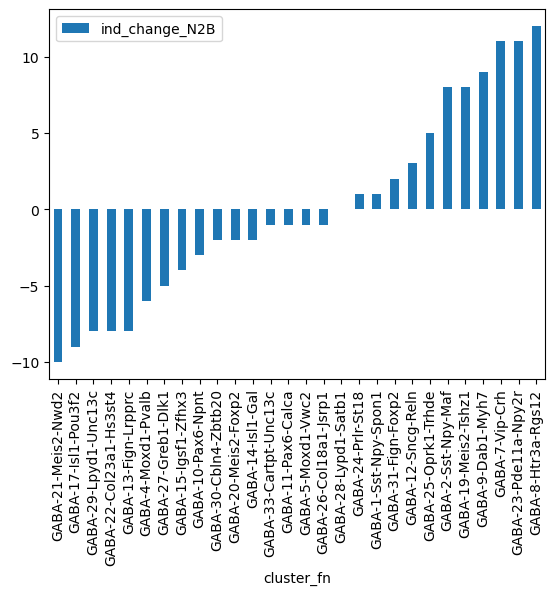

In [261]:
cts_ind_changed_N2B.sort_values(by='ind_change_N2B').plot.bar()
plt.show()